In [10]:
using Pkg
Pkg.activate("..")

using Distributions, LinearAlgebra, MiCRM, EasyFit, Distances, StatsBase, Clustering
using OrdinaryDiffEq, DiffEqCallbacks
using CairoMakie, Colors, ColorSchemes
using JLD2
using Optim, ForwardDiff

  Activating project at `~/Projects/Working/ErCite/chemicalstressors`


In [11]:
Pkg.status()

Status `~/Projects/Working/ErCite/chemicalstressors/Project.toml`
⌃ [13f3f980] CairoMakie v0.10.0
  [aaaa29a8] Clustering v0.14.3
  [35d6a980] ColorSchemes v3.20.0
⌃ [5ae59095] Colors v0.12.8
  [459566f4] DiffEqCallbacks v2.24.3
  [b4f34e82] Distances v0.10.7
  [31c24e10] Distributions v0.25.79
  [fde71243] EasyFit v0.5.7
⌃ [f6369f11] ForwardDiff v0.10.32
  [033835bb] JLD2 v0.4.29
⌅ [20f20a25] MakieCore v0.6.0
  [a39c0ef7] MiCRM v0.0.2 `https://github.com/CleggTom/MiCRM.jl.git#main`
  [429524aa] Optim v1.7.4
⌃ [1dea7af3] OrdinaryDiffEq v6.35.1
  [2913bbd2] StatsBase v0.33.21
⌃ [0c5d862f] Symbolics v4.13.0
Info Packages marked with ⌃ and ⌅ have new versions available, but those with ⌅ are restricted by compatibility constraints from upgrading. To see why use `status --outdated`


# Introduction

In this notebook I do some exploratory analysis of a model in which stressors are linked to consumer dynamics by uptake. This uptake has negative consequences for consumers and removes the resources from the environment. 

The basic model is as follows:
\begin{align}
    \frac{dC}{dt} &= C_i \left(\sum_{\alpha} R_{\alpha} u_{i \alpha} \gamma_{\alpha}(1 - \lambda) - m_i\right)\\
    \frac{dR}{dt} &= \rho_\alpha - R_{\alpha} \omega_\alpha - \sum_{i} C_i  R_{\alpha} u_{i \alpha} + \sum_{\beta} R_{\beta} \sum_{i} C_i u_{i \beta} l_{\beta \alpha}
\end{align}

Or in a diagram:

<center>
<img src="figs/StressorDiagram.png" width="400">
</center>

Consumers uptake and leak resources as normal. The stressor acts as a resource but has a negative effect on growth of consumer populations. 

## Code

In [12]:
#solve system with stressor
#derivatives
function growth_MiCRM_detox!(dx,x,p,t,i)
    #mortality
    dx[i] += -p.m[i] * x[i]
    #resource uptake
    for α = 1:p.M
        tmp = 0.0
        for β = 1:p.M
            tmp += p.l[α,β]
        end
        dx[i] += x[α + p.N] * x[i] * p.u[i,α] * (1 - tmp) * p.kw.γ[i,α]
    end
end

#derivative function
dx!(dx,x,p,t) = MiCRM.Simulations.dx!(dx,x,p,t; growth! = growth_MiCRM_detox!)


#params
function fu(N,M,kw)
    u = zeros(N,M)
    u[:, 1 : (M-1)] .= MiCRM.Parameters.modular_uptake(N,M - 1, N_modules = 5, s_ratio = kw[:u_ratio]) * kw[:u_tot]
    u[:, end] .= ones(N)
    return(u)
end

function fl(N,M,kw)
    l = MiCRM.Parameters.modular_leakage(M; N_modules = 5, s_ratio = kw[:l_ratio], λ = kw[:λ])
    #dont leak to or from stressor
    l[:,end] .= 0.0
    l[end,:] .= 0.0
    [l[i,:] .=  kw[:λ] * l[i,:] ./ sum(l[i,:]) for i = 1:(M-1)]
    return(l)
end

#Dirchlet U matricies
function dirchlet_uptake(N,M,kw)
    u = zeros(N,M)
    u[:,1 : end-1] .= Array(rand(Dirichlet(M-1, kw[:au]), N)')
    u[:,end] .= rand(Dirichlet(N, 1.0), 1)
    return(u)
end

#Dirchlet L matricies
function dirchlet_leakage(N,M,kw)
    l = zeros(M,M)
    for α = 1:M-2
        l[α, α+1 : end-1] .= rand(Dirichlet(M - 1 - α, kw[:al]), 1)
    end
    # l[1 : end-1, 1 : end-1] .= Array(rand(Dirichlet(M-1, kw[:al]), M-1)')
    return(l * kw[:λ])
end

function fρ(N,M,kw)
    ρ = zeros(M) 
    ρ[1] = M * M
    ρ[end] = 0.0
    return(ρ)
end

f_ω(N,M,kw) = fill(1.0, M)

f_ω (generic function with 1 method)

In [13]:
N,M = 25,25

#gamma
γ = ones(N,M)
γ[:,end] .= -1.0

#generate test parameters
p = MiCRM.Parameters.generate_params(N, M, f_u = dirchlet_uptake, f_l = dirchlet_leakage, f_ρ = fρ, λ = 0.7, γ = γ, au = 0.2, al = 1.0)

#simualtion params
x0 = ones(N+M)
x0[end] = 0.0
t = (0.0,1e5)

prob = ODEProblem(dx!, x0, t, p)

@time sol1 = solve(prob, AutoTsit5(Rosenbrock23()));
@time sol2 = solve(prob, AutoTsit5(Rosenbrock23()), callback = TerminateSteadyState(1e-8,1e-6));

  4.305170 seconds (10.68 M allocations: 736.465 MiB, 3.02% gc time, 96.62% compilation time)
  2.353791 seconds (6.53 M allocations: 452.354 MiB, 3.23% gc time, 94.19% compilation time)


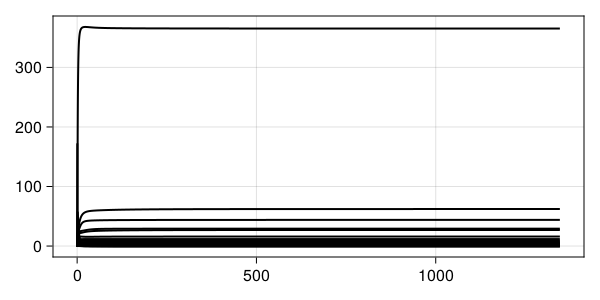

In [14]:
plot_sol(sol,ax) = Makie.series!(ax, sol.t, sol[:,:], solid_color = "black")

f = Figure(resolution = (600,300))
ax = Axis(f[1,1])
plot_sol(sol2,ax)
f

# Simulation details

## Measuring responses

we consider three aspects of the stress response over different timescales. 

1. Degree of amplification of a pulse of chemical stressor
2. The rate of return after a pulse of chemical stressor
3. The change in equilbirium state following chronic exposure to the stressor. 

<img src="figs/pulse.png" width="400">


## Interactions

We consider how these responses are modified by the community context and how interactions between consumer populations affect the response. 

* cooperation increases robustness? (Oña 2022)

* competition increases sensitvtiy (Violle et al. 2010)


### partitioning leakage and competition

To partition the contributions of leakage and competition for resources we first consider the dyanmic equations, extracting the total effects of uptake and leakage on the $\alpha^{\text{th}}$ resource:

\begin{align}
    L_{\alpha} &= \sum_{i \beta} C_i R_{\beta} u_{i \beta} l_{\beta \alpha}, \\
    U_{\alpha} &= \sum_{i} C_i R_{\alpha} u_{i \alpha}.
\end{align}

We then consdier how these fluxes are affected by consumer species with the quantites:

\begin{align}
    \frac{d L_{\alpha}}{d C_i} &= \sum_{\beta} R_{\beta} u_{i \beta} l_{\beta \alpha}, \\
    \frac{d U_{\alpha}}{d C_i} &= R_{\alpha} u_{i \alpha},
\end{align}

and weight their effects on consumers by considering the effect of resources from consumer growth

\begin{align}
    \frac{d g_i}{d R_{\alpha}} = u_{i \alpha} \gamma_{i \alpha} (1 - \lambda)
\end{align}

thus the effect of consumer $j$ on $i$ due to leakage and uptake respectively are:
\begin{align}
    a^{L}_{i j} &= \sum_{\alpha} \frac{d g_i}{d R_{\alpha}} \frac{d L_{\alpha}}{d C_j} = \sum_{\alpha} \big[u_{i \alpha} \gamma_{i \alpha} (1 - \lambda) \big] \big[\sum_{\beta} R_{\beta} u_{j \beta} l_{\beta \alpha} \big] \\
    a^{U}_{i j} &= \sum_{\alpha} \frac{d g_i}{d R_{\alpha}} \frac{d U_{\alpha}}{d C_j} = \sum_{\alpha} \big[u_{i \alpha} \gamma_{i \alpha} (1 - \lambda) \big] \big[R_{\alpha} u_{j \alpha} \big]
\end{align}

In [15]:
dgdR(p, R, i, a) = p.u[i,a] * p.kw.γ[i,a] * (1 - p.kw.λ)

function dLdC(p, R, j, a)
    v = 0.0
    for b = 1:p.M
        v += p.l[b,a] * R[b] * p.u[j,b]
    end
    return v
end

dUdC(p, R, j, a) = R[a] * p.u[j,a]

function a_L(p,R,i,j)
    v = 0.0
    for a = 1:p.M
        v += dgdR(p,R,i,a) * dLdC(p,R,j,a)
    end
    return(v)
end

function a_U(p,R,i,j)
    v = 0.0
    for a = 1:p.M
        v += dgdR(p,R,i,a) * dUdC(p,R,j,a)
    end
    return(v)
end

get_U_mat(p,R) = [a_U(p,R,i,j) for i = 1:p.N , j = 1:p.N]
get_L_mat(p,R) = [a_L(p,R,i,j) for i = 1:p.N , j = 1:p.N]

get_L_mat (generic function with 1 method)

In [16]:
# get_U_mat(p,R)
# get_L_mat(p,R)

# @time a_U_mat = get_U_mat(p,R)
# @time a_L_mat = get_L_mat(p,R);

In [17]:
function treepositions(hc::Hclust; useheight = true, orientation = :vertical)
    order = StatsBase.indexmap(hc.order)
    nodepos = Dict(-i => (float(order[i]), 0.0) for i in hc.order)
    xs = []
    ys = []
    for i in 1:size(hc.merges, 1)
        x1, y1 = nodepos[hc.merges[i, 1]]
        x2, y2 = nodepos[hc.merges[i, 2]]
        xpos = (x1 + x2) / 2
        ypos = useheight ?  hc.heights[i] : (max(y1, y2) + 1)
        nodepos[i] = (xpos, ypos)
        push!(xs, [x1, x1, x2, x2])
        push!(ys, [y1, ypos, ypos, y2])
    end
    if orientation == :horizontal
        return ys, xs
    else
        return xs, ys
    end
end
function dendrogram(h; color = :blue, kwargs...)
    CairoMakie.Axis(Figure()[1, 1])
    for (x, y) in zip(treepositions(h; kwargs...)...)
        lines!(x, y; color)
    end
    current_figure()
end

dendrogram (generic function with 1 method)

  0.000021 seconds (1 allocation: 5.062 KiB)
  0.000226 seconds (1 allocation: 5.062 KiB)


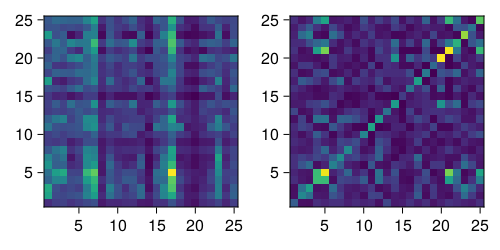

In [18]:
R = sol1[end][p.N+1 : end]

get_U_mat(p,R)
get_L_mat(p,R)

@time a_U_mat = get_U_mat(p,R)
@time a_L_mat = get_L_mat(p,R)

c = Clustering.hclust(Symmetric(a_U_mat))

f = Figure(resolution = (500,250))

ax1 = Axis(f[1,1])
ax2 = Axis(f[1,2])

heatmap!(ax1, a_L_mat[c.order,c.order])
heatmap!(ax2, a_U_mat[c.order,c.order])

f

## Resource Specialisation $s$
the degree to which consumers tend to specialise on their own resources

<center>
<img src="figs/Uptake_spec.png" width="400">
</center>

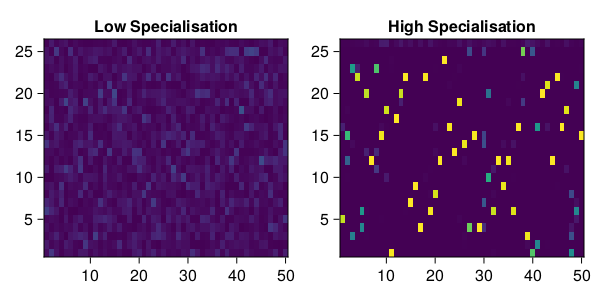

In [19]:
f = Figure(resolution = (600,300))

ax1 = Axis(f[1,1],title = "Low Specialisation")
ax2 = Axis(f[1,2],title = "High Specialisation")

heatmap!(ax1, dirchlet_uptake(50,26,Dict(:au => 1.0)), colorrange = (0.0,1.0))
heatmap!(ax2, dirchlet_uptake(50,26,Dict(:au => 0.01)), colorrange = (0.0,1.0))

f

## Leakage $\lambda$
The amount of resources leaked as metabolic by-products

<center>
<img src="figs/Leakage.png" width="400">
</center>

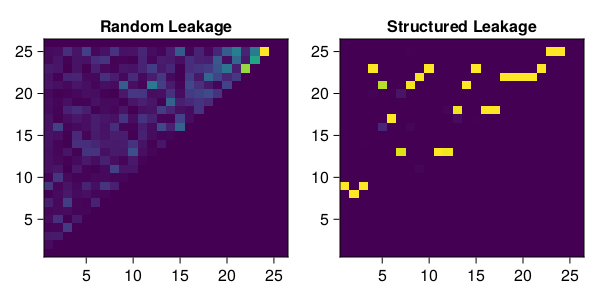

In [20]:
f = Figure(resolution = (600,300))

ax1 = Axis(f[1,1],title = "Random Leakage")
ax2 = Axis(f[1,2],title = "Structured Leakage")

heatmap!(ax1, dirchlet_leakage(50,26,Dict(:al => 1.0, :λ => 1.0)), colorrange = (0.0,1.0))
heatmap!(ax2, dirchlet_leakage(50,26,Dict(:al => 0.01, :λ => 1.0)), colorrange = (0.0,1.0))


f

In [258]:
r = JLD2.load("../data/detox_simulations.jld2")
analysis = JLD2.load("../data/analysis.jld2")

N_r,N_u,N_λ,N_ρ = size(r["J"])

u_vec =  (range(0, 2, length = N_u))
ρ_vec = range(-4, -4, length = N_ρ)
λ_vec = [0.1, 0.3, 0.7]

mean_no_diag(A) = (sum(A) - sum(A[diagind(A)])) / (prod(size(A) .- [0, 1]))

mean_no_diag (generic function with 1 method)

# Results

## Uptake Modularity

### Return Time

The longterm response is determined by the structure of the jacobian matrix. Here we see that the degree of consumer specialisation reduces return time. That is specialist dominated systems recover faster from perturbations.

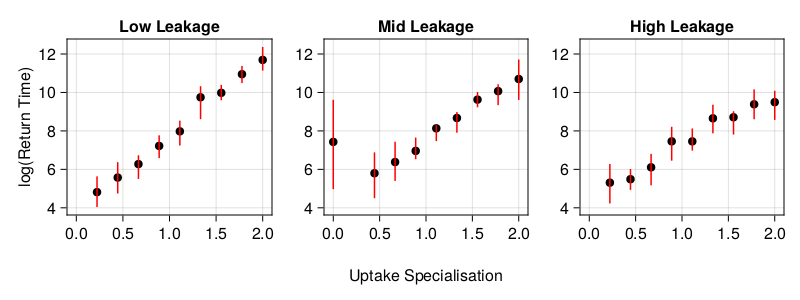

In [247]:
#get return rates
return_rates = map(x -> isa(x, Complex) ? -1 / (x.re) : -1/x, analysis["Rinf"])
indx = findall(return_rates .< 0)
return_rates[indx] .= 0.0
return_rates = log.(return_rates)

f = Figure(resolution = (800,300))
ax = [Axis(f[1,i], ) for i = 1:3]
[ax[i].title = string(["Low","Mid","High"][i]," Leakage") for i = 1:3]
ax[1].ylabel = "log(Return Time)"

for u = 1:N_u
    for l = 1:N_λ
        #means
        scatter!(ax[l], u_vec[u], mean(return_rates[:,u,l,1]), color = "black")

        #error
        lb = mean(return_rates[:,u,l,1]) - quantile(return_rates[:,u,l,1],0.25)
        ub = quantile(return_rates[:,u,l,1],0.75) - mean(return_rates[:,u,l,1])

        errorbars!(ax[l], u_vec[u], mean(return_rates[:,u,l,1]),[lb],[ub],color = "red")
        
        
        # boxplot!(ax[l], fill(u_vec[u],N_r), return_rates[:,u,l,1], color = "grey", width = 0.1)
    end
end

linkaxes!(ax...)
xlabel = Label(f[2, 1:3], "Uptake Specialisation", rotation = 0)

f

In [248]:
function get_uptake_flux(mass,p)
    mass == nothing && return(0) 
    C = mass[1:25]
    R = mass[26:end]

    up_R = zeros(25)
    # a = 25
    for a = 1:p.N
        for i = 1:p.M-1
            up_R[a] -= p.u[i,a] * C[i] * R[a]
            for b = 1:p.M-1
                up_R[b] += p.u[i,b] * C[i] * R[b] * p.l[b,a]
            end

        end
    end
    return(sum(up_R))
end

get_uptake_flux (generic function with 1 method)

In [249]:
get_C(mass) = sum(mass[1 : 25])
get_R(mass) = sum(mass[26 : end-1])

C_mass = get_C.(r["mass"])
R_mass = get_R.(r["mass"]);
up_flux = get_uptake_flux.(r["mass"],r["p"])

#unstable solutions


# #relative mass
ΔC = similar(C_mass)
ΔR = similar(C_mass)
ΔU = similar(C_mass)

for rep = 1:N_r
    ΔC[rep,:,:,:] = C_mass[rep,:,:,:] .- C_mass[rep,:,:,1]
    ΔR[rep,:,:,:] = R_mass[rep,:,:,:] .- R_mass[rep,:,:,1]
    ΔU[rep,:,:,:] = up_flux[rep,:,:,:] .- up_flux[rep,:,:,1]
end

ΔC[isnan.(ΔC)] .= 0.0
ΔR[isnan.(ΔR)] .= 0.0
ΔU[isnan.(ΔU)] .= 0.0;

### Change in Biomass

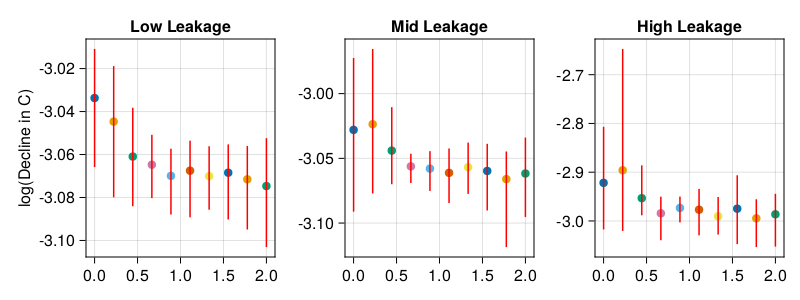

In [255]:
f = Figure(resolution = (800,300))
ax = [Axis(f[1,i], ) for i = 1:3]
[ax[i].title = string(["Low","Mid","High"][i]," Leakage") for i = 1:3]
ax[1].ylabel = "log(Decline in C)"


for u = 1:N_u
    for l = 1:N_λ
        ΔC_plt = -ΔC[:,u,l,4]
        filter!(x -> x > 0, ΔC_plt)
        ΔC_plt = log.(ΔC_plt)
        
        #mean
        scatter!(ax[l], u_vec[u], mean(ΔC_plt))
        
        #error
        lb = (mean(ΔC_plt) - quantile(ΔC_plt,0.05))
        ub = (quantile(ΔC_plt,0.95) - mean(ΔC_plt))
        
         errorbars!(ax[l], u_vec[u], (mean(ΔC_plt)),[lb],[ub],color = "red")
    end
end

# linkaxes!(ax...)


f

### Change in Resources

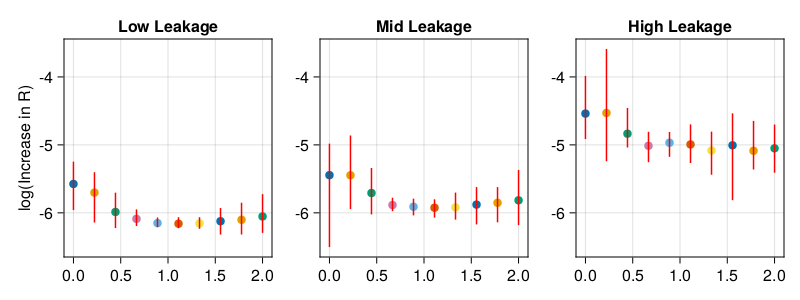

In [253]:
f = Figure(resolution = (800,300))
ax = [Axis(f[1,i], ) for i = 1:3]
[ax[i].title = string(["Low","Mid","High"][i]," Leakage") for i = 1:3]
ax[1].ylabel = "log(Increase in R)"


for u = 1:N_u
    for l = 1:N_λ
        ΔR_plt = ΔR[:,u,l,4]
        filter!(x -> x > 0, ΔR_plt)
        ΔR_plt = log.(ΔR_plt)
        
        #mean
        scatter!(ax[l], u_vec[u], mean(ΔR_plt))
        
        #error
        lb = (mean(ΔR_plt) - quantile(ΔR_plt,0.05))
        ub = (quantile(ΔR_plt,0.95) - mean(ΔR_plt))
        
         errorbars!(ax[l], u_vec[u], (mean(ΔR_plt)),[lb],[ub],color = "red")
    end
end

linkaxes!(ax...)

f

### Uptake Flux

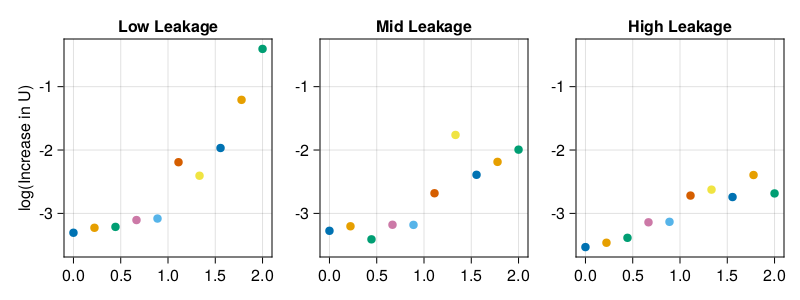

In [264]:
f = Figure(resolution = (800,300))
ax = [Axis(f[1,i], ) for i = 1:3]
[ax[i].title = string(["Low","Mid","High"][i]," Leakage") for i = 1:3]
ax[1].ylabel = "log(Increase in U)"


for u = 1:N_u
    for l = 1:N_λ
        ΔU_plt = -ΔU[:,u,l,4]
        filter!(x -> x > 0, ΔU_plt)
        ΔU_plt = log.(ΔU_plt)
        
        #mean
        scatter!(ax[l], u_vec[u], mean(ΔU_plt))
        
        #error
        # lb = (mean(ΔU_plt) - quantile(ΔU_plt,0.05))
        # ub = (quantile(ΔU_plt,0.95) - mean(ΔU_plt))
        
         # errorbars!(ax[l], u_vec[u], (mean(ΔU_plt)),[lb],[ub],color = "red")
    end
end

linkaxes!(ax...)

f

In [285]:
log_2(x) = x >= 0 ? log(x) : log(0)

series(log_2(ΔR[:,1,1,:]), solid_color = "black")

LoadError: MethodError: no method matching isless(::Int64, ::Matrix{Float64})
[0mClosest candidates are:
[0m  isless(::Real, [91m::Union{StatsBase.PValue, StatsBase.TestStat}[39m) at ~/.julia/packages/StatsBase/XgjIN/src/statmodels.jl:91
[0m  isless(::Real, [91m::DualNumbers.Dual{<:Real}[39m) at ~/.julia/packages/DualNumbers/5knFX/src/dual.jl:182
[0m  isless(::Real, [91m::Static.StaticInteger{Y}[39m) where Y at ~/.julia/packages/Static/Ldb7F/src/Static.jl:456
[0m  ...

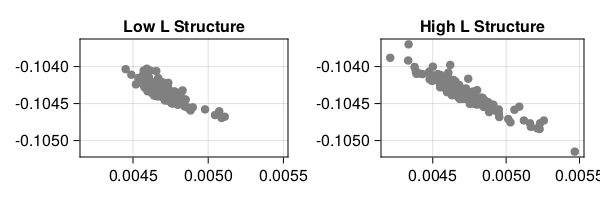

In [23]:
us_vec = range(0, 2, length = N_u)

f = Figure(resolution = (600,200))
ax1 = Axis(f[1,1], title = "Low L Structure")
ax2 = Axis(f[1,2], title = "High L Structure")

# for u = 1:N_u
    scatter!(ax1, ΔR[:,:,1,1,1][:], ΔC[:,:,1,1,1][:], width = 0.1, color = "grey") 
    scatter!(ax2, ΔR[:,:,2,1,1][:], ΔC[:,:,2,1,1][:], width = 0.1, color = "grey") 
# end

linkaxes!(ax1,ax2)

f

### Interpretation

Overall the system response to stressors seems relatively independent of the modularity/specialisation in the system. Both the pulse and press responses are invariant with respect to the the modularity in the system. 

# approximations

\begin{align}
        R_{tot}^* &\approx \frac{\bar{m} +u_s R_s^*}{\bar{u} (1 - \lambda)} \\
        C_{tot}^* &\approx \frac{\rho_{tot} - \omega_{tot}}{(1 - \lambda) \bar{u} R_{tot}^*} = \frac{\rho_{tot} - \omega_{tot}}{\bar{m} +u_s R_s^*}
\end{align}

Adding stressor will increase resource abundance but reduce consumer biomass

\begin{align}
    u_{tot} = (1-\lambda) \sum_{i,\alpha} u_{i \alpha} C_i R_i \approx \bar{u} R_{tot} C_{tot} = \frac{\rho_{tot} - \omega_{tot}}{(1 - \lambda)}
\end{align}

In [907]:
#testing quantities
f_Rtot(p,Rs) = mean(p.m + p.u[:,end] * Rs) / (mean(p.u[:,1:24]) * (1 - p.kw.λ))
f_Ctot(p,Rs) = (sum(p.ρ) - f_Rtot(p, Rs))/((1 - p.kw.λ)*mean(p.u[:,1:24]) * f_Rtot(p,Rs))
f_Rs(p,Ctot) = p.ρ[end] / (p.ω[end] + Ctot) 

f_Rs (generic function with 1 method)

In [920]:
p_ = r["p"][1,20,20,3,end]
m_ = r["mass"][1,20,20,3,end];

In [921]:
println("resources: ", sum(m_[26:end-1]),"  ",f_Rtot(p_,m_[end]))
println("Consumers: ", sum(m_[1:25]),"  ",f_Ctot(p_,m_[end]))
println("Stressor: ",  m_[end],"  ",Rs(p_,f_Ctot(p_,m_[end])))

resources: 82.53566061939888  80.15459944801874
Consumers: 516.4662718737012  519.8408117700154
Stressor: 0.0019324931002345043  0.0019199724318868547
